In [ ]:
!nvidia-smi

# Setup:

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
import torch.nn.functional as F
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from utils import *
from lightning_utils import *
import JHTDB_sim_op

import model_agnostic_BNN # the script is now fully compatible with the current model
from model_agnostic_BNN import get_BNN_pred_distribution, get_BNN_pred_moments

In [ ]:
#stride=[1.609,1.625,1.203] # WNO
stride=1.47 # ablation study
#stride=1.0
time_chunking=10
ablation_models = ['Everything-large', # 0
                   'Everything-small', # 1
                   'Control-small', # 2
                   'Control-No-Output-LN', # 3
                   'MixtureOfExperts-normalized-small', # 4
                   'MixtureOfExperts-small', # 5
                   'RecursiveSteps-small', # 6
                   'CNN-small-k4', # 7
                   'Everything-small-k4', # 8
                   'WNO-800-epochs', # 9
                   'Everything-WNO-stride-800-epochs', #10
                  ]
ablation_model_index = 8
model_name = ablation_models[ablation_model_index]

In [ ]:
########### Parse Model Choice Settings ###########

stride=1.47 # ablation study
time_chunking=10

optional_model_kwd_args = {}

# set time chunking and stride based on model type
if 'Control' in model_name or 'MixtureOfExperts' in model_name:
    time_chunking=2
if 'large' in model_name:
    stride=1.0
if 'WNO' in model_name:
    print('using WNO experts')
    stride=[1.609,1.625,1.203] # WNO-stride gives 64x16x64
    optional_model_kwd_args['make_expert'] = WNO3d
elif 'CNN' in model_name:
    print('using CNN experts')
    CNN_expert = lambda *args, out_norm_groups=1, skip_connections=True, **kwd_args: \
        CNN(*args, out_norm_groups=out_norm_groups, skip_connections=skip_connections, **kwd_args)
    optional_model_kwd_args['make_expert'] = CNN_expert

print(f'{model_name=}, {stride=}, {time_chunking=}')

# Data Loading:

In [ ]:
import torch
import JHTDB_sim_op
import pytorch_lightning as L

# preserves random state
def preload_dataset(dataset):
    Xs, ys = [], []
    for i in range(len(dataset)):
        X, y = dataset[i]
        Xs.append(X)
        ys.append(y)
    Xs, ys = torch.stack(Xs), torch.stack(ys)
    print(f'dataset min={min(Xs.min(),ys.min())}, max={max(Xs.max(),ys.max())}')
    return torch.utils.data.TensorDataset(Xs, ys)

def peek_random(verbose=True): # Use fork_rng() to peek at the next random number
    with torch.random.fork_rng():
        rand_peek = torch.randn([]).item()
        if verbose: print(f'{rand_peek=:.5}') # sanity check RNG
    return rand_peek

def recreate_datasets(path, time_chunking=10, stride=1, full_long_horizon=False):
    L.seed_everything(0)
    long_horizon=100
    full_dataset = JHTDB_sim_op.JHTDB_Channel('data/turbulence_output', time_chunking=time_chunking, stride=stride)
    dataset_long_horizon = JHTDB_sim_op.JHTDB_Channel('data/turbulence_output', time_chunking=long_horizon, stride=stride) # called dataloader_idx_1 in tensorboard
    assert f'{peek_random():.5}'=='1.541'
    _, val_long_horizon = torch.utils.data.random_split(dataset_long_horizon, [0.5, 0.5]) # 50% ensures there are two validation steps
    assert f'{peek_random():.5}'=='2.2628'
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
    if full_long_horizon: val_long_horizon=dataset_long_horizon
    return full_dataset, train_dataset, val_dataset, val_long_horizon

In [ ]:
dataset, train_dataset, val_dataset, val_long_horizon = recreate_datasets('data/turbulence_output', time_chunking=time_chunking, stride=stride)
#val_dataset, val_long_horizon = preload_dataset(val_dataset), preload_dataset(val_long_horizon)

In [ ]:
X, y = dataset[0]
Xy = torch.cat([X[...,None], y],axis=-1) # recombine!
print(f'{Xy.shape=}, {X.shape=}, {y.shape=}')

field_size = list(X.shape[1:])
print(f'{field_size=}')

In [ ]:
import numpy as np
def make_4d_sim_fig(sim_data, vel_comp_idx:int, prefix='', time_stride=999, num_z=4, vel_component_name = ['X','Y','Z']):
    from grid_figures import GridFigure
    fig = GridFigure(f'{prefix}3d Channel Flow: {vel_component_name[vel_comp_idx]} Velocity')
    sim_data = sim_data.cpu()
    for z in np.linspace(0, sim_data.shape[-2]-1, num=num_z, dtype=int):
        fig.add_3d_row(sim_data[vel_comp_idx,:,:,z], f'{z=}', x_title_func=lambda t: f't={t*time_stride}',
                       img_getter=lambda array_3d, t: array_3d[:,:,t].T, time_samples=list(range(sim_data.shape[-1])))
    fig.show()

make_4d_sim_fig(Xy, 0, time_stride=1, num_z=field_size[-1]//8)

### Here we load the actual DNS dataset:

In [ ]:
'''
def load_full_dataset_field(dataset_path, stride=1):
    import os
    cache_path = f'{dataset_path}/full_field_cache_stride={stride}.pt'
    if os.path.exists(cache_path): # almost x3 faster!
        print('loading from cache!')
        return torch.load(cache_path)

    dataset = JHTDB_sim_op.JHTDB_Channel(dataset_path, time_chunking=1, stride=stride)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=16)
    x, _ = next(iter(data_loader))
    print(f'{x.shape=}')

    full_field = torch.stack([x.squeeze() for x, _ in data_loader], axis=-1)
    print(f'{full_field.shape=}, {full_field.device=}')
    torch.save(full_field, cache_path)
    return full_field
import time
start_time = time.time()
real_channel_flow = load_full_dataset_field('data/turbulence_output', stride=stride).detach() # should we stride?

field_size = list(real_channel_flow.shape[1:-1])
print(f'{field_size=}')

print(f'loading duration (sec): {time.time()-start_time}')
''';

In [ ]:
import sys
sys.path.append('./WNO/Version_2.0.0')
from wno3d_NS import WNO3d

from glob import glob
get_best_long_horizon_model = lambda ckpt_dir: sorted(glob(f'{ckpt_dir}/*.ckpt'))[0] # 'last.ckpt' comes after 'epoch*.ckpt' alphabetically (epoch*.ckpt is the "best long horizon model")
get_best_long_horizon_model('./lightning_logs/paper/Control-No-Output-LN')

# wrapper to nullify the prior_cfg kwd_arg (for compatibility)
from JHTDB_sim_op import POU_NetSimulator, PPOU_NetSimulator
class POU_NetSimulator(POU_NetSimulator):
    def __init__(self, *args, prior_cfg={}, train_dataset_size=None, **kwd_args):
        super().__init__(*args, **kwd_args)

# deprecated
def concat_forward_wrap_VI_model(VI_model):
    import copy
    class ConcatForwardWrapper(type(VI_model)):
        def forward(self, *args, **kwd_args):
            mu, sigma = super().forward(*args, **kwd_args)
            return torch.cat([mu, sigma],axis=1)
    VI_model = copy.copy(VI_model)
    VI_model.__class__ = ConcatForwardWrapper # wrap the forward to concatenate the outputs
    return VI_model

class PredMomentsWrapper(PPOU_NetSimulator):
    def forward(self, x_inputs, **kwd_args):
        if PredMomentsWrapper.n_moment_samples>1:
            mu, sigma = get_BNN_pred_moments(super().forward, x_inputs, 
                                             n_samples=PredMomentsWrapper.n_moment_samples, **kwd_args)
        else: mu, sigma = super().forward(x_inputs, **kwd_args)
        return mu, sigma
PredMomentsWrapper.n_moment_samples=1

import utils

def load_model(path, device='cuda', override_class=PPOU_NetSimulator, **kwd_args):
    ''' Wraps up all the nonsense involved in loading an inference model properly into one function. '''
    # user-provided kwd_args has precedence in update
    kwd_args = {'n_inputs': 3, 'n_outputs': 3, 'ndims': 3} | kwd_args

    print(f'loading model from path: {path}')
    try:
        print('loading VI model...')
        simulator = override_class.Sim(*field_size) # Sim(ulator) class (e.g. Sim or Sim_UQ), first 3 args are X,Y,Z dimensions
        model = override_class.load_from_checkpoint(path, simulator=simulator, **kwd_args)
    except Exception as e:
        try:
            fail=False
            print('loading deterministic model...')
            POU_NetSimulator.Sim(*field_size)
            model = POU_NetSimulator.load_from_checkpoint(path, simulator=simulator, **kwd_args)
        except: fail=True
        if fail: raise

    model = model.to(device)
    model.eval()

    print(f'num model parameters: {utils.count_parameters(model):.5e}')

    # freeze everything
    for parameter in model.parameters():
        parameter.requires_grad=False
    print('done!')
    return model

'''
ablation_models = ['Everything-large', # 0
                   'Everything-small', # 1
                   'Control-small', # 2
                   'Control-No-Output-LN', # 3
                   'MixtureOfExperts-normalized-small', # 4
                   'MixtureOfExperts-small', # 5
                   'RecursiveSteps-small'] # 6
#ablation_model_index = 3
''';

#model = load_model(get_best_long_horizon_model('./lightning_logs/paper/WNO-150-epochs'), make_expert=WNO3d)
#optional_model_kwd_args = {}
model = load_model(f'./lightning_logs/paper/{model_name}/last.ckpt', override_class=PredMomentsWrapper, **optional_model_kwd_args)
sim_model = model.simulator

In [ ]:
#dataset, train_dataset, val_dataset, val_long_horizon
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, num_workers=4)
val_long_loader = torch.utils.data.DataLoader(val_long_horizon, batch_size=4, num_workers=2)

In [ ]:
L.seed_everything(0)

#concat_model = concat_forward_wrap_VI_model(model.cuda())

import model_agnostic_BNN
LPPC_val = model_agnostic_BNN.log_posterior_predictive_check(model, val_loader)
print(f'{LPPC_val=}')
#org_steps=model.n_steps
#model.n_steps=99
LPPC_val_long = model_agnostic_BNN.log_posterior_predictive_check(model, val_long_loader, n_steps=99)
print(f'{LPPC_val_long=}')
#model.n_steps=org_steps

In [ ]:
L.seed_everything(0)
PredMomentsWrapper.n_moment_samples=25
trainer = L.Trainer()
val_dataloaders = [val_loader, val_long_loader] # long validation loader causes various problems with profiler & GPU utilization...
trainer.validate(model=model, dataloaders=val_dataloaders)
PredMomentsWrapper.n_moment_samples=1

In [ ]:
import utils
print(f'num model parameters: {utils.count_parameters(concat_model):.5e}')

# 3d Expert Partitions

In [ ]:
u0 = sim_model.genIC().detach() # random IC
gating_weights, topk = model.gating_net(u0[None])
topk_sort_idx = torch.argsort(topk)
gating_weights, topk = gating_weights[:,topk_sort_idx], topk[topk_sort_idx]
gating_weights = gating_weights[0].cpu() # ditch batch dim & move to cpu
print(f'{gating_weights.shape=}')

In [ ]:
# add the zero expert weight
ones = torch.ones(1,*gating_weights.shape[1:], dtype=gating_weights.dtype, device=gating_weights.device)
zero_weight = ones - gating_weights.sum(axis=0)
gating_weights = torch.cat([zero_weight, gating_weights], axis=0)
print(f'{gating_weights.shape=}')

In [ ]:
# check if others are different? turns out the others are used a little bit
print('spatially averaged gating weights for each expert:', torch.vmap(torch.mean)(gating_weights).numpy())

In [ ]:
from grid_figures import GridFigure
fig = GridFigure(f'3d Expert Partitions', y_title_vertical=False)

print('NOTE: expert #0 is also literally the "Zero Expert"')
for expert_i in range(gating_weights.shape[0]):
    fig.add_3d_row(gating_weights[expert_i], f'expert #{expert_i}', x_title_func=lambda t: f'z={t}',
                   img_getter=lambda array_3d, t: array_3d[:,:,t].T, time_samples=list(range(0,field_size[-1],10)))
fig.show()

In [ ]:
from utils import StopExecution
raise StopExecution

# Run Simulations
(Choose of the methods below, and run just that)

## Run Regular Simulation:
(with one epistemic sample or deterministic model)

In [ ]:
%pdb off
#u0 = sim_model.genIC().detach() # random IC
u0 = real_channel_flow[..., 0].to(model.device)
with torch.inference_mode():
    sim_steps = model(u0, n_steps=4000, intermediate_output_stride=999)
    #sim_steps = sim_model.evolve(u0, n=4001, intermediate_outputs=True, intermediate_output_stride=999)

# handle uq
if type(sim_steps) is tuple:
    assert len(sim_steps)==2
    sim_steps, sim_steps_uq = sim_steps # keep them seperate so later code works
    sim_steps_uq=sim_steps_uq.cpu()
sim_steps = sim_steps.cpu()

## Run UQ Simulations
(choose one of the UQ-oriented methods below)

In [ ]:
%pdb off

import model_agnostic_BNN # the script is now fully compatible with the current model
from model_agnostic_BNN import get_BNN_pred_distribution, get_BNN_pred_moments

# TODO: modify below so that it can handle sparisty of the f40 dataset
# wrapper of above that also computes absolute error & has custom logic for the problem
def get_BNN_pred_moments_and_error(model, dataset, n_samples=10, n_steps=4000, intermediate_output_stride=999, **kwd_args):
    u0 = dataset[..., 0].to(model.device)
    sim_steps, sim_steps_uq = get_BNN_pred_moments(model, u0, n_samples=n_samples, n_steps=n_steps,
                                                   intermediate_output_stride=intermediate_output_stride, **kwd_args)
    with torch.inference_mode():
        abs_error = (dataset[...,::intermediate_output_stride]-sim_steps).abs()
    return sim_steps.cpu().detach(), sim_steps_uq.cpu().detach(), abs_error.cpu().detach()

In [ ]:
'''
u0 = real_channel_flow[..., 0].to(model.device)
mu, sigma = get_BNN_pred_moments(model, u0, n_samples=10, n_steps=4000)
''';

### Sample Learned Simulation Predictive Distribution (Aleatoric and Epistemic Uncertainty)

In [ ]:
u0 = real_channel_flow[..., 0].to(model.device)
pred_distribution = get_BNN_pred_distribution(model, u0, n_samples=10, n_steps=4000, intermediate_output_stride=999)
pred_distribution = torch.distributions.normal.Normal(*pred_distribution)#, validate_args=False)
pred_samples = pred_distribution.sample() # then sample the actual predictions from the sampled aleatoric distributions

print(f'pred_samples size GBs: {np.prod(pred_samples.shape)*4/1e9}')
tshow(pred_samples)

### Or Get Predictive Distribution Median and IQR

In [ ]:
def torch_IQR(tensor, axis=None):
    upper_quantile = tensor.quantile(0.75, axis=axis)
    lower_quantile = tensor.quantile(0.25, axis=axis)
    IQR = (upper_quantile-lower_quantile).abs()
    return IQR

pred_median = pred_samples.median(axis=0).values.cpu()
pred_IQR = torch_IQR(pred_samples, axis=0).cpu()

In [ ]:
sim_steps, sim_steps_uq = pred_median, pred_IQR
tshow(sim_steps)
tshow(sim_steps_uq)

### Or Directly Compute Predictive Distribution Mean and Variance using Law of Total Variance (more sample efficient)

In [ ]:
u0 = real_channel_flow[..., 0].to(model.device)
sim_steps, sim_steps_uq, abs_error = get_BNN_pred_moments_and_error(model, real_channel_flow)
sim_steps_OOD, sim_steps_uq_OOD, abs_error_OOD = get_BNN_pred_moments_and_error(model, no_filter_channel_flow)

In [ ]:
print(f'{u0.shape=}\n{sim_steps.shape=}\n{real_channel_flow.shape=}')

## Display Simulation:

In [ ]:
'''
def make_4d_sim_fig(sim_data, vel_comp_idx:int, prefix='', time_stride=999, vel_component_name = ['X','Y','Z']):
    from grid_figures import GridFigure
    fig = GridFigure(f'{prefix}3d Channel Flow: {vel_component_name[vel_comp_idx]} Velocity')
    sim_data = sim_data.cpu()
    for z in np.linspace(0, sim_data.shape[-2]-1, num=4, dtype=int):
        fig.add_3d_row(sim_data[vel_comp_idx,:,:,z], f'{z=}', x_title_func=lambda t: f't={t*time_stride}',
                       img_getter=lambda array_3d, t: array_3d[:,:,t].T, time_samples=list(range(sim_data.shape[-1])))
    fig.show()
''';

def create_all_simulation_figs(predicted_sim_steps, true_sim_steps=None, predicted_prefix='Learned ', true_prefix='DNS ',
                               time_stride=999, true_data_already_sparse=False):
    if not true_data_already_sparse:
        true_sim_steps = true_sim_steps[...,::time_stride]
    for i in range(3):
        print('#'*50 + f'\n{predicted_prefix}Simulation:')
        make_4d_sim_fig(predicted_sim_steps, i, time_stride=time_stride, prefix=predicted_prefix)
        if true_sim_steps is not None:
            print('#'*50 + f'\n{true_prefix}Simulation:')
            make_4d_sim_fig(true_sim_steps, i, time_stride=time_stride, prefix=true_prefix)

import random
create_all_simulation_figs(sim_steps, real_channel_flow)

# Ravi's Implementation of Energy Spectrum:
**Ravi's FLow Stats Equations:**

A good place to start is looking at the energy spectrum which describes how the energy is distributed across wavelengths.
Here’s how to get it: <br>
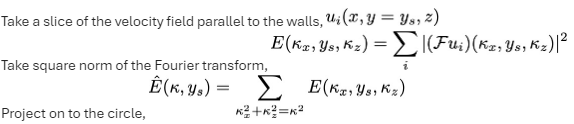

NOTE: Below is my implementation of the the energy spectrum stats code.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def E(u):
    uh = np.fft.rfftn(u,axes=[0,2])
    return np.sum(np.abs(uh)**2,axis=-1)

def npmap(f,a):
    return np.array(list(map(f,a)))

def E1d(u,epsilon_multiplier=1.,nk=30,Lx=8*np.pi,Ly=2.0,Lz=3*np.pi):

    '''

    arguments:

        Lx,Ly,Lz: domain lengths

        epsilon_multiplier: for width of ring to project to point

        nk: number of points along radius to project on to

        u: input function (**IMPORTANT**: channel dimension now comes first!)

    output: 
        energy spectrum from u. First axis is the energy spectrum. Second is y coordinate
    '''
    u = u.moveaxis(0,-1) # we need to move the channel dimension (usually infront) to back for compatibility
    
    nx,ny,nz = u.shape[0:-1]
    kx = np.fft.fftfreq(nx,d=Lx/nx)
    kz = np.fft.rfftfreq(nz,d=Lz/nz)
    dk = np.sqrt(kx[1]**2 + kz[1]**2)
    epsilon = epsilon_multiplier*dk
    Kxz = np.stack(np.meshgrid(kx,kz,indexing='ij'),axis=-1)
    K = np.sqrt(Kxz[...,0]**2 + Kxz[...,1]**2)
    k = np.linspace(0,min(np.max(kx),np.max(kz)),nk)
    Eu = E(u)
    return k,2.*np.transpose(npmap(
        lambda j:npmap(
            lambda ki:np.sum(Eu[:,j][np.abs(K-ki)<epsilon]),
            k),
        np.arange(ny)))

# This has incomplete support for UQ, take a look at it and develop it further.
# Right now there should be an error bar on the 2nd plot only.
def make_energy_spectrum_figure(u, uq=None, k_min=0.0, **kwd_args):
    k,Ek = E1d(u, **kwd_args)
    plt.loglog(k,Ek[:,1:-1])
    y = k**(-5/3)
    plt.plot(k,3e5*y,'r--',linewidth=4)
    plt.xlabel(r'$k$')
    plt.ylabel(r'$\hat{E}(u)$')
    plt.figure()
    
    plt.plot(k[k>k_min],1e5*y[k>k_min],'r--',linewidth=4)
    if uq is None:
        plt.loglog(k[k>k_min],np.mean(Ek[k>k_min],axis=1))
    else:
        plt.xscale('log')
        plt.yscale('log')
        k,Ek_plus = E1d(u+uq, **kwd_args) # upper bound
        k,Ek_minus = E1d(u-uq, **kwd_args) # lower bound
        yerr = np.mean(((Ek_plus[k>k_min]-Ek_minus[k>k_min])**2)**0.5, axis=1)/2 # central difference
        plt.errorbar(k[k>k_min], np.mean(Ek[k>k_min],axis=1), yerr=yerr)

## Make Energy Spectrum Figure for DNS

In [ ]:
make_energy_spectrum_figure(real_channel_flow[...,-1], k_min=1.0, epsilon_multiplier=0.5) # use last timestep

## Make Energy Spectrum Figure for Learned Simulation

In [ ]:
make_energy_spectrum_figure(sim_steps[..., -1], k_min=1.0, epsilon_multiplier=0.5) # use last timestep

## Create confidence 95% interval for mean energy spectrum
Technically for this be a real confidence interval you need to use the very first "Regular Simulation" option, \
otherwise you get a mixture distribution from sampling epistemic uncertainty...

In [ ]:
%pdb on
make_energy_spectrum_figure(sim_steps[..., -1], sim_steps_uq[...,-1]*1.96, k_min=0.0, epsilon_multiplier=0.5)